# How does past temperature affect COVID-19 case growth?

In [1]:
import time
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import scipy

## Tunables

In [2]:
# The weather variable to observe. Try TAVG, TMIN, TMAX, PRCP (daily temperature avg/min/max, daily precipitation)
ELEMENT = 'TAVG'

In [3]:
# Require this many cumulative cases in a country to accept daily growth factors
MIN_CASES = 30

In [4]:
# The temperature we correlate with is the day's temperature compared to the mean of this long window.
# The model seems to be fairly sensitive to this? (14d gives no significant result). None = do not filter.
TEMP_SMOOTH_PERIOD = None    # '3d'

In [5]:
# Predict new cases from old cases (without weather data) from this many previous days
NUM_DIFFS_TO_USE = 2

In [6]:
NUM_CONTROL_SAMPLES = 50000  # 5000 is a reasonably fast, good number; 10x that for good results

In [7]:
# How many days' offset to consider at maximum
NUM_DAYS = 30

In [8]:
COUNTRY_COORDS = {
    'US': (40.7789, -73.9692),  # New York City
    'IT': (45.4717, 9.1892),    # Milan
    'CN': (30.6, 114.05),       # Wuhan
    'ES': (40.3, -3.723),       # Madrid
    'DE': (48.13, 11.57),       # Munich
    'FR': (48.86, 2.35),        # Paris
    'IR': (34.64, 50.876),      # Qom
    'UK': (51.507, -0.128),     # London
    'CH': (46.00, 8.95),        # Lugano
    'KR': (35.87, 128.6),       # Daegu
    'NL': (51.55, 5.08),        # Tilburg
    'AT': (48.2, 16.37),        # Vienna
    'TR': (41.01, 28.955),      # Istanbul chosen arbitrarily (no clear which cities are epicenters)
    'CA': (45.51, -73.56),      # Montreal
    'PT': (38.73, -9.15),       # Lisbon
    'NO': (59.91, 10.75),       # Oslo,
    'AU': (-37.81, 144.96),     # Melbourne
    'IL': (31.78, 35.22),       # Jerusalem
    'BR': (-23.55, -46.63),     # São Paulo
    'SE': (59.33, 18.07),       # Stockholm
    'CZ': (50.08, 14.42),       # Prague
    'IE': (53.35, -6.27),       # Dublin
    'MY': (3.15, 101.70),       # Kuala Lumpur
    'DE': (55.68, 12.57),       # Copenhagen
    'CL': (-33.45, -70.67),     # Santiago
    'LU': (49.61, 6.13),        # Luxemburg City
    'EC': (-2.18, -79.88),      # Guayaquil
    'JP': (35.69, 139.69),      # Tokyo
    'PL': (52.23, 20.02),       # Warsaw
    'RO': (44.43, 26.10),       # Bucharest
    'PK': (24.86, 67.01),       # Karachi
    'RU': (55.76, 37.62),       # Moscow
    'TH': (13.75, 100.49),      # Bangkok
    'SA': (26.56, 50.00),       # Qatif
    'ZA': (-26.20, 28.05),      # Johannesburg
    'FI': (60.1667, 24.95),     # Helsinki
}

In [9]:
STATIONS = {'US': 'USW00014732',   # New York Laguardia AP,
            'IT': 'ITM00016088',   # Ghedi
            'CN': 'CHM00057494',   # Wuhan
            'ES': 'SPE00120296',   # Madrid Getafe
            'DE': 'GMM00010870',   # Schwaigermoos, near Munich
            'FR': 'FR000007150',   # Paris Le Bourget
            'IR': 'IRM00040785',   # Kashan, near Qom
            'UK': 'UKM00003772',   # London Heathrow
            'CH': 'SZ000009480',   # Lugano
            'KR': 'KSM00047138',   # Pohang, near Daegu
            'NL': 'NLM00006260',   # de Bilt, near Tilburg
            'AT': 'AU000005901',   # Wien
            'TR': 'TUM00017064',   # Istanbul Bolge (Kartal)
            'CA': 'CA007024745',   # McTavish
            'PT': 'PO000008535',   # Lisboa Geofisica
            'NO': 'NOM00001492',   # Oslo Blindern,
            'AU': 'ASN00087031',   # Laverton RAAF
            'IL': 'ISM00040180',   # Ben Gurion
            'BR': 'BR00E3-0520',   # São Paulo aeroport
            'SE': 'SWM00002589',   # Gotska Sandön A
            'CZ': 'EZM00011520',   # Praha-Libus
            'IE': 'EI000003969',   # Dublin Phoenix Park
            'MY': 'MYM00048647',   # Sultan Abdul Aziz Shah Intl
            'CL': 'CIM00085577',   # Quinta Normal
            'LU': 'LU000006590',   # Luxembourg airport
            'EC': 'PEM00084370',   # Pedro Canga
            'JP': 'JA000047662',   # Tokyo
            'PL': 'PLM00012375',   # Okecie
            'RO': 'ROE00108889',   # Bucuresti-Baneasa
            'PK': 'PKM00041780',   # Jinnah Intl
            'RU': 'RSM00027612',   # Moscow
            'TH': 'TH000048455',   # Bangkok metropolis
            'SA': 'SAW00032502',   # Dhahran
            'ZA': 'SFM00068368',   # Johannesburg Intl
            'FI': 'FIE00142101',   # Helsinki Ilmala,
           }
assert len(set(STATIONS.values())) == len(set(STATIONS)), 'Two countries map to same station; currently this breaks our logic'

## Read temperature data

In [10]:
temps = pd.read_csv('data/2020.csv.gz', names='station date element value measure_flag quality_flag source_flag obs_time'.split(),
                    dtype={'measure_flag': str, 'quality_flag': str, 'source_flag': str, 'obs_time': str},
                    parse_dates=['date'])

In [11]:
temps = temps[temps.quality_flag.isna()].drop('quality_flag', axis=1)

## Code to allow finding good stations near the coordinates specified in STATIONS

In [12]:
temp_stations = pd.read_fwf('data/ghcnd-stations.txt', names='station lat lon elev state name gsn hcn wmo_id'.split(),
                            colspecs=[(0, 11), (12, 20), (21, 30), (31, 37), (38, 40), (41, 71), (72, 75), (76, 79), (80, 85)])

In [13]:
def haversine(lat1, lon1, lat2, lon2, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    lat1, lon1 = np.radians([lat1, lon1])
    lat2, lon2 = np.radians([lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [14]:
obs_counts = temps[temps.element==ELEMENT].groupby('station').value.count().rename('obs_count')

In [15]:
def find_nearest():
    for country, (lat, lon) in COUNTRY_COORDS.items():
        if country in STATIONS:
            continue
        stations = temp_stations.copy()
        stations['dist'] = haversine(lat, lon, stations.lat, stations.lon)
        stations = stations.sort_values('dist')
        stations = stations.merge(obs_counts, on='station').set_index('station')
        print(f'Nearest to {country}:')
        print(stations['obs_count dist elev name'.split()].iloc[:10])
        print()
        
find_nearest()

In [16]:
print(f'#{ELEMENT} observations on stations:')
els = temps[temps.element==ELEMENT]
els = els[els.station.isin(STATIONS.values())]
print(els.groupby('station').count().value)
max_measurements = els.groupby('station').count().value.max()
meas_threshold = max_measurements / 2
no_meas_countries = []
for country, station in STATIONS.items():
    if (els.station == station).sum() < meas_threshold:
        print(f'*** Less than {meas_threshold} {ELEMENT} observations in country {country} ({station}). Dropping country.')
        no_meas_countries.append(country)

for country in no_meas_countries:
    del COUNTRY_COORDS[country]
    del STATIONS[country]

#TAVG observations on stations:
station
ASN00087031    84
AU000005901    85
BR00E3-0520    85
CA007024745    86
CHM00057494    85
CIM00085577    85
EI000003969    85
EZM00011520    85
FIE00142101    85
FR000007150    85
GMM00010870    85
IRM00040785    85
ISM00040180    85
ITM00016088    85
JA000047662    85
KSM00047138    85
LU000006590    85
MYM00048647    85
NLM00006260    85
NOM00001492    85
PEM00084370    85
PKM00041780    85
PLM00012375    85
PO000008535    85
ROE00108889    85
RSM00027612    85
SAW00032502    85
SFM00068368    84
SPE00120296    85
SWM00002589    85
SZ000009480    85
TH000048455    85
TUM00017064    85
UKM00003772    85
USW00014732    84
Name: value, dtype: int64


In [17]:
temps.station = temps.station.map({v: k for k, v in STATIONS.items()})

In [18]:
temps = temps[~temps.station.isna()]

In [19]:
temps.element.value_counts()

TAVG    2973
PRCP    2082
TMIN    1774
TMAX    1585
SNWD     358
SNOW      86
WDF5      85
WDF2      85
WSF2      85
AWND      85
WSF5      85
WT01      29
WSFG      20
WDFG      20
WT08      14
WT02       4
WT04       2
Name: element, dtype: int64

In [20]:
temps = temps[temps.element.isin('TMIN TMAX TAVG PRCP'.split())]

In [21]:
# The data has tenths of degrees, tenths of millimeters
temps.value /= 10

In [22]:
temps = pd.pivot_table(temps, index=['date'], columns=['element', 'station'], values='value')

## Read COVID-19 data

In [23]:
covid = pd.read_csv('data/COVID-19-geographic-disbtribution-worldwide.csv',
                   parse_dates=['dateRep'], na_values=[''], keep_default_na=False).rename(
    columns={'countryterritoryCode': 'country', 'popData2018': 'population'})

In [24]:
covid['date'] = pd.to_datetime(covid[['day', 'month', 'year']])
covid = covid['date cases deaths country population geoId'.split()]
covid = covid.pivot(index='date', columns='geoId')
covid = covid.sort_values(by='date')

The cases and deaths columns in the dataset contain new cases/deaths, not the cumulative count.

In [25]:
covid

cases                                                        ...  \
geoId         AD    AE    AF   AG   AI    AL    AM   AO     AR      AT  ...   
date                                                                    ...   
2019-12-31   NaN   0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN     0.0  ...   
2020-01-01   NaN   0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN     0.0  ...   
2020-01-02   NaN   0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN     0.0  ...   
2020-01-03   NaN   0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN     0.0  ...   
2020-01-04   NaN   0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN     0.0  ...   
...          ...   ...   ...  ...  ...   ...   ...  ...    ...     ...  ...   
2020-03-24  20.0  45.0   6.0  0.0  NaN  11.0   4.0  0.0   35.0   855.0  ...   
2020-03-25  31.0  50.0   2.0  2.0  NaN  23.0  71.0  0.0   86.0   796.0  ...   
2020-03-26  24.0  85.0  33.0  0.0  NaN  23.0  25.0  0.0  115.0   606.0  ...   
2020-03-27  36.0   0.0   0.0  4.0  2.0  28.0  39.0  1.0   87.0  1141.0  ...   
2020-03-28  43.0  72.0  16.0  0.0  0.0  12.0  43.0  1.0  101.0   668.0  ...   

           population                                                       \
geoId              VA        VC          VE       VG        VI          VN   
date                                                                         
2019-12-31        NaN       NaN         NaN      NaN       NaN  95540395.0   
2020-01-01        NaN       NaN         NaN      NaN       NaN  95540395.0   
2020-01-02        NaN       NaN         NaN      NaN       NaN  95540395.0   
2020-01-03        NaN       NaN         NaN      NaN       NaN  95540395.0   
2020-01-04        NaN       NaN         NaN      NaN       NaN  95540395.0   
...               ...       ...         ...      ...       ...         ...   
2020-03-24     1000.0       NaN  28870195.0      NaN  106977.0  95540395.0   
2020-03-25     1000.0  110210.0  28870195.0      NaN  106977.0  95540395.0   
2020-03-26     1000.0  110210.0  28870195.0      NaN  106977.0  95540395.0   
2020-03-27     1000.0  110210.0  28870195.0  29802.0  106977.0  95540395.0   
2020-03-28     1000.0  110210.0  28870195.0  29802.0  106977.0  95540395.0   

                                                           
geoId              XK          ZA          ZM          ZW  
date                                                       
2019-12-31        NaN         NaN         NaN         NaN  
2020-01-01        NaN         NaN         NaN         NaN  
2020-01-02        NaN         NaN         NaN         NaN  
2020-01-03        NaN         NaN         NaN         NaN  
2020-01-04        NaN         NaN         NaN         NaN  
...               ...         ...         ...         ...  
2020-03-24  1845300.0  57779622.0  17351822.0  14439018.0  
2020-03-25  1845300.0  57779622.0  17351822.0  14439018.0  
2020-03-26  1845300.0  57779622.0  17351822.0  14439018.0  
2020-03-27  1845300.0  57779622.0  17351822.0  14439018.0  
2020-03-28  1845300.0  57779622.0  17351822.0  14439018.0  

[89 rows x 784 columns]

In [26]:
covid = covid.join(covid[['cases']].cumsum().rename(columns={'cases': 'cases_cum'}))
covid = covid.join(covid[['deaths']].cumsum().rename(columns={'deaths': 'deaths_cum'}))

In [27]:
cases_cum = covid.cases_cum[covid.cases_cum >= MIN_CASES]
cases_cum = cases_cum[cases_cum.first_valid_index():]

In [28]:
def crop_series(ser):
    ser = ser[ser >= MIN_CASES]
    return ser[ser.first_valid_index():]

def plot_log(ser, label=None):
    ser[ser.first_valid_index():].plot(logy=True, label=label)

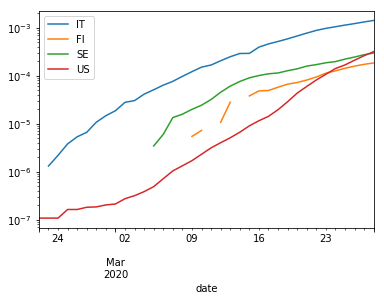

In [29]:
plot_log(cases_cum.IT/covid.population.IT)
plot_log(cases_cum.FI/covid.population.FI)
plot_log(cases_cum.SE/covid.population.SE)
plot_log(cases_cum.US/covid.population.US)

plt.legend();

## Predict new cases from case history alone

In [30]:
PRED_VARS = [f'x{n}' for n in range(1, NUM_DIFFS_TO_USE+1)]

shifted = [cases_cum] + [cases_cum.shift(freq=f'{days}d') for days in range(1, NUM_DIFFS_TO_USE+2)]
pred_data = pd.concat([cases_cum] + [a/b for a, b in zip(shifted, shifted[1:])],
                      keys=['cases_cum', 'y'] + PRED_VARS,
                      axis=1).stack().dropna()

In [31]:
pred_data

cases_cum         y        x1        x2
date       geoId                                         
2020-01-06 CN          59.0  1.000000  1.340909  1.000000
2020-01-07 CN          59.0  1.000000  1.000000  1.340909
2020-01-08 CN          59.0  1.000000  1.000000  1.000000
2020-01-09 CN          59.0  1.000000  1.000000  1.000000
2020-01-10 CN          59.0  1.000000  1.000000  1.000000
...                     ...       ...       ...       ...
2020-03-28 UZ         104.0  1.253012  1.276923  1.181818
           VE         119.0  1.112150  1.009434  1.164835
           VN         169.0  1.104575  1.033784  1.104478
           XK          86.0  1.088608  1.112676  1.126984
           ZA        1170.0  1.262136  1.307475  1.272890

[1590 rows x 4 columns]

In [32]:
# A better predictor would make this... better.
regr = LinearRegression().fit(pred_data[PRED_VARS], pred_data.y.to_numpy().reshape(-1, 1))

## Compute the residual of our cases-history-only prediction and the known true cases value

In [33]:
pred_data['y_pred'] = regr.predict(pred_data[PRED_VARS])
pred_data['y_residual'] = pred_data.y - pred_data.y_pred
pred_data.y_residual -= pred_data.y_residual.mean()
pred_data['cases_cum_pred'] = pred_data.cases_cum / pred_data.y * pred_data.y_pred

pred_data = pred_data.unstack()

pred_data

cases_cum                                                    \
geoId             CN JPG11668     SG      TH      JP      KR        US   
date                                                                     
2020-01-06      59.0      NaN    NaN     NaN     NaN     NaN       NaN   
2020-01-07      59.0      NaN    NaN     NaN     NaN     NaN       NaN   
2020-01-08      59.0      NaN    NaN     NaN     NaN     NaN       NaN   
2020-01-09      59.0      NaN    NaN     NaN     NaN     NaN       NaN   
2020-01-10      59.0      NaN    NaN     NaN     NaN     NaN       NaN   
...              ...      ...    ...     ...     ...     ...       ...   
2020-03-24   81748.0      NaN  509.0   827.0  1128.0  9037.0   46442.0   
2020-03-25   81847.0      NaN  558.0   934.0  1193.0  9137.0   55231.0   
2020-03-26   81968.0      NaN  568.0  1045.0  1268.0  9241.0   69194.0   
2020-03-27   82079.0      NaN  594.0  1136.0  1364.0  9332.0   85991.0   
2020-03-28   82213.0      NaN  732.0  1136.0  1499.0  9478.0  104686.0   

                                     ... cases_cum_pred                        \
geoId            IT       IR     TW  ...             MU         RW         BO   
date                                 ...                                        
2020-01-06      NaN      NaN    NaN  ...            NaN        NaN        NaN   
2020-01-07      NaN      NaN    NaN  ...            NaN        NaN        NaN   
2020-01-08      NaN      NaN    NaN  ...            NaN        NaN        NaN   
2020-01-09      NaN      NaN    NaN  ...            NaN        NaN        NaN   
2020-01-10      NaN      NaN    NaN  ...            NaN        NaN        NaN   
...             ...      ...    ...  ...            ...        ...        ...   
2020-03-24  63927.0  23049.0  195.0  ...            NaN        NaN        NaN   
2020-03-25  69176.0  24811.0  216.0  ...            NaN        NaN        NaN   
2020-03-26  74386.0  27017.0  235.0  ...            NaN        NaN        NaN   
2020-03-27  80539.0  29406.0  252.0  ...      55.901691  46.395153        NaN   
2020-03-28  86498.0  32332.0  267.0  ...     101.921971  57.436739  76.365152   

                                                                     \
geoId              CD          CI          GH         GU         KG   
date                                                                  
2020-01-06        NaN         NaN         NaN        NaN        NaN   
2020-01-07        NaN         NaN         NaN        NaN        NaN   
2020-01-08        NaN         NaN         NaN        NaN        NaN   
2020-01-09        NaN         NaN         NaN        NaN        NaN   
2020-01-10        NaN         NaN         NaN        NaN        NaN   
...               ...         ...         ...        ...        ...   
2020-03-24        NaN         NaN         NaN        NaN        NaN   
2020-03-25        NaN         NaN         NaN        NaN        NaN   
2020-03-26        NaN         NaN         NaN        NaN        NaN   
2020-03-27        NaN         NaN         NaN        NaN        NaN   
2020-03-28  61.557056  111.369381  176.050327  58.570119  49.003506   

                                  
geoId              ME         PY  
date                              
2020-01-06        NaN        NaN  
2020-01-07        NaN        NaN  
2020-01-08        NaN        NaN  
2020-01-09        NaN        NaN  
2020-01-10        NaN        NaN  
...               ...        ...  
2020-03-24        NaN        NaN  
2020-03-25        NaN        NaN  
2020-03-26        NaN        NaN  
2020-03-27        NaN        NaN  
2020-03-28  78.952632  61.102028  

[83 rows x 826 columns]

## Some plots to show how our predictor works

In [34]:
def plot_pred(data, country):
    plot_log(pred_data.cases_cum[country], f'{country} real')
    plot_log(pred_data.cases_cum_pred[country], f'{country} pred')
    plt.legend()
    print(f'log-loss: {(pred_data.y[country]-pred_data.y_pred[country]).pow(2).mean()}')

log-loss: 0.013237003216609169


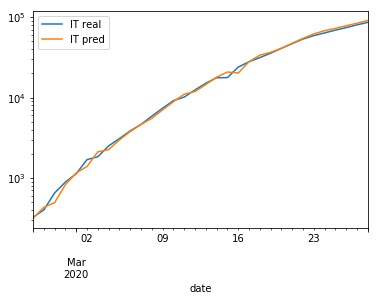

In [35]:
plot_pred(pred_data, 'IT')

log-loss: 0.002329303352258459


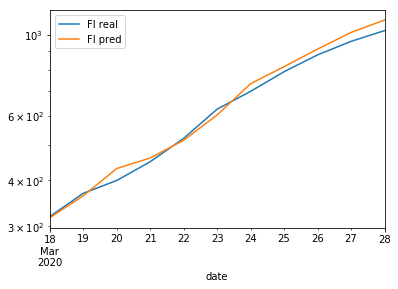

In [36]:
plot_pred(pred_data, 'FI')

log-loss: 0.010875867940712842


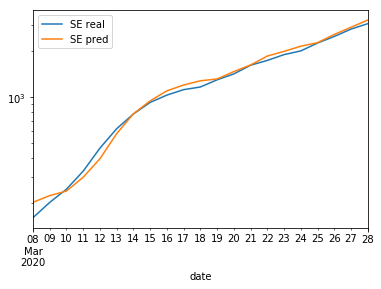

In [37]:
plot_pred(pred_data, 'SE')

log-loss: 0.043059131394588


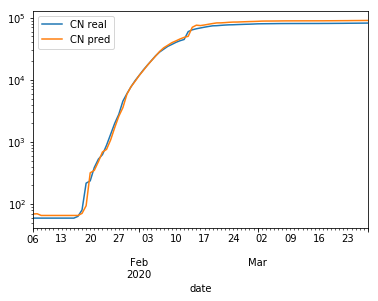

In [38]:
plot_pred(pred_data, 'CN')

In [39]:
# Copy temperature data to pred_data
for country in STATIONS:
    for elem in 'TAVG TMIN TMAX PRCP'.split():
        try:
            pred_data[elem, country] = temps[elem, country]
        except KeyError:
            pred_data[elem, country] = np.nan

## The per-country correlation is messy

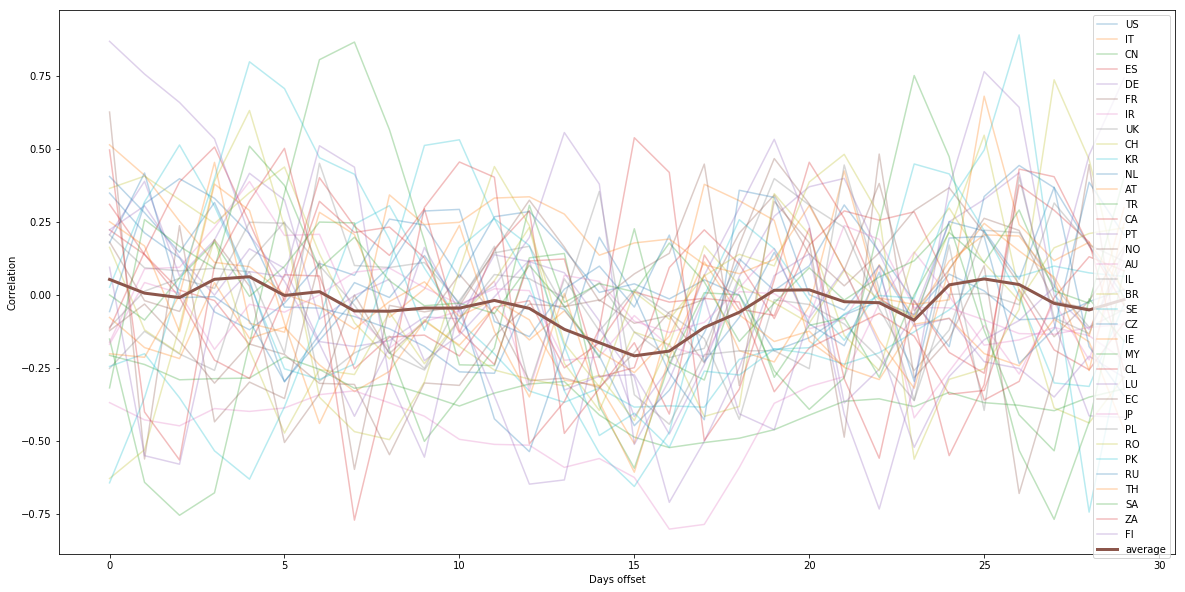

In [40]:
# TODO: A matshow plot would probably demonstrate this better

plt.figure(figsize=(20, 10))
all_countries = []
for country in STATIONS:
    a = []
    for days in range(NUM_DAYS):
        a.append(pred_data[ELEMENT, country].shift(freq=f'{days}d').corr(pred_data.y_residual[country]))
    a = np.array(a)
    all_countries.append(a)
    plt.plot(range(NUM_DAYS), a, label=country, alpha=.3)
all_countries = np.array(all_countries)
plt.plot(range(NUM_DAYS), np.mean(all_countries, axis=0), label='average', linewidth=3)
plt.xlabel('Days offset')
plt.ylabel('Correlation')
plt.legend();

## Calculate a correlation matrix of daily new cases in country Y vs temperature in country X, for each of the day offsets.

In [41]:
def calc_corr():
    '''Returns a dataframe indexed by (cases_country, days) with (temp_country) as columns.'''
    a = []
    if TEMP_SMOOTH_PERIOD is not None:
        # high pass filter    
        temp_smoothed = pred_data[ELEMENT].rolling(TEMP_SMOOTH_PERIOD).mean()
    else:
        temp_smoothed = pred_data[ELEMENT]
    countries = list(temp_smoothed.columns)
    for days in range(0, NUM_DAYS):
        temp_shifted = temp_smoothed.shift(freq=f'{days}d')
        for temp_country in countries:
            for cases_country in countries:
                c = temp_shifted[cases_country].corr(pred_data.y_residual[temp_country])
                a.append((cases_country, days, temp_country, c))
    a = np.array(a)
    return pd.DataFrame(dict(
        cases_country=a[:, 0].astype(str),
        days=a[:, 1].astype(int),
        temp_country=a[:, 2].astype(str),
        corr_=a[:, 3].astype(float))).set_index(['cases_country', 'days']).pivot(columns='temp_country')

In [42]:
corr_mtx = calc_corr()

In [43]:
corr_mtx

corr_                                          \
temp_country              AT        AU        BR        CA        CH   
cases_country days                                                     
AT            0     0.513018 -0.252673  0.364815  0.018473  0.142530   
              1     0.408774 -0.016765  0.307760 -0.226153  0.141824   
              2     0.251631  0.287623  0.183062 -0.035792  0.116407   
              3     0.110748  0.474637  0.271585 -0.051231  0.070699   
              4     0.095914  0.191346  0.251146 -0.046139  0.170595   
...                      ...       ...       ...       ...       ...   
ZA            25    0.341889  0.369420  0.222671  0.097496 -0.070482   
              26    0.580031  0.155577 -0.023729 -0.029742  0.135145   
              27    0.432152  0.150122  0.033057  0.232807  0.068272   
              28    0.139507  0.209518  0.219360  0.459253 -0.121287   
              29   -0.061855  0.042736 -0.113517  0.309718 -0.001260   

                                                                      ...  \
temp_country              CL        CN        CZ        DE        EC  ...   
cases_country days                                                    ...   
AT            0     0.098576 -0.203893  0.483114  0.301898  0.032495  ...   
              1     0.098750 -0.285944  0.255996  0.313071  0.480052  ...   
              2    -0.036446 -0.270686  0.144858  0.277066  0.278082  ...   
              3    -0.028990 -0.278456  0.216165  0.098020  0.480964  ...   
              4     0.136548 -0.330583  0.046997  0.089427  0.047621  ...   
...                      ...       ...       ...       ...       ...  ...   
ZA            25    0.226006  0.091521 -0.040872 -0.023160  0.186423  ...   
              26    0.228076  0.088067  0.065004 -0.054871  0.072938  ...   
              27    0.058270  0.171576  0.267635 -0.095899 -0.202199  ...   
              28    0.166279  0.113391  0.226808  0.053334 -0.085966  ...   
              29    0.406367  0.062722  0.134745  0.190846  0.156585  ...   

                                                                      \
temp_country              PT        RO        RU        SA        SE   
cases_country days                                                     
AT            0     0.382051 -0.638208  0.202620 -0.002514  0.471255   
              1     0.363603 -0.515169  0.202567  0.054956  0.436454   
              2     0.366748 -0.422776  0.082842  0.206456  0.129076   
              3     0.465204 -0.143789  0.017768  0.024030  0.006292   
              4     0.282675  0.280673 -0.381102  0.094889 -0.129916   
...                      ...       ...       ...       ...       ...   
ZA            25    0.488093  0.137409  0.009164  0.032873  0.297310   
              26    0.504659  0.416823 -0.229997 -0.152741  0.422656   
              27    0.562348  0.251922 -0.267044  0.031889  0.284136   
              28    0.305894 -0.326782  0.138875  0.218712  0.045784   
              29   -0.028751 -0.551317  0.406466 -0.318854 -0.105291   

                                                                      
temp_country              TH        TR        UK        US        ZA  
cases_country days                                                    
AT            0    -0.152194  0.854260 -0.041136  0.391173  0.094462  
              1     0.281957  0.882156  0.112960  0.167913  0.043979  
              2     0.339968  0.351417  0.191140  0.258421 -0.398170  
              3     0.355399 -0.103643  0.270848  0.011574 -0.244188  
              4     0.257097 -0.517676 -0.018950 -0.048123  0.062764  
...                      ...       ...       ...       ...       ...  
ZA            25   -0.029668 -0.345813 -0.157990 -0.153866 -0.307873  
              26   -0.137324 -0.560931 -0.173391 -0.161682  0.430015  
              27   -0.242724 -0.554534  0.173547 -0.184724  0.403823  
              28   -0.078322 -0.039891  0.171909 -0.315960  0.166920  
   

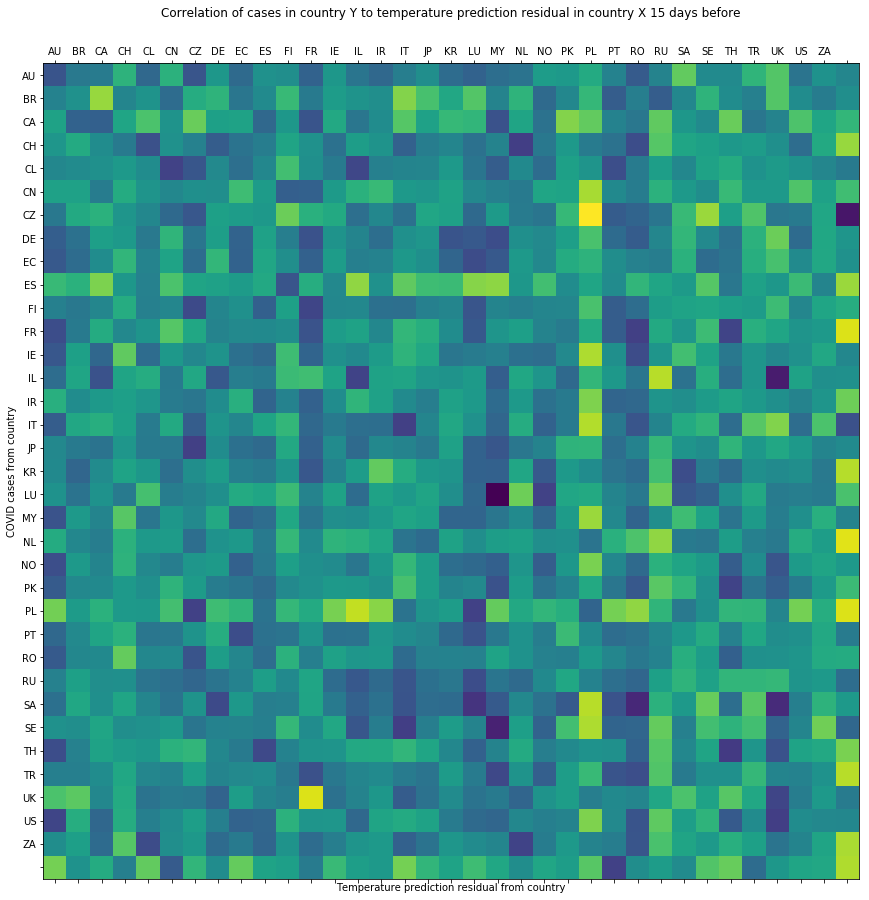

In [44]:
CORR_MTX_PLOT_DAY = 15
fig, ax = plt.subplots(figsize=(15, 15))
ax.matshow(corr_mtx.loc(axis=0)[:, CORR_MTX_PLOT_DAY])
ax.set_xlabel('Temperature prediction residual from country')
ax.set_ylabel('COVID cases from country')
ax.set_xticklabels(corr_mtx.corr_.columns)
ax.set_yticklabels(corr_mtx.corr_.columns)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_title(f'Correlation of cases in country Y to temperature prediction residual in country X {CORR_MTX_PLOT_DAY} days before');

In [45]:
def np_dropna(a):
    '''Drop nan values from a 1-dimensional numpy array.'''
    assert len(a.shape) == 1, a.shape
    return a[~np.isnan(a)]

## Generate control data by correlating COVID cases with temperatures in random stations

In [46]:
def calc_control_data():
    '''Returns something of the form (days, *)'''
    # TODO: Vectorize this
    # TODO: should we weigh countries equally or by the number of valid days?
    # samples_by_country = pred_data.cases_cum.count()
    a = []
    countries = list(corr_mtx.corr_.columns)
    for i in range(NUM_CONTROL_SAMPLES):
        if i % 5000 == 0:
            print(i, time.asctime(), flush=True)
        random.shuffle(countries)
        a.append(corr_mtx.corr_[countries].groupby('days').apply(np.diag).apply(np_dropna).apply(np.mean).to_numpy())
    return np.array(a).T

In [47]:
control_data = calc_control_data()

0 Sun Mar 29 16:45:00 2020
5000 Sun Mar 29 16:45:33 2020
10000 Sun Mar 29 16:46:06 2020
15000 Sun Mar 29 16:46:39 2020
20000 Sun Mar 29 16:47:12 2020
25000 Sun Mar 29 16:47:45 2020
30000 Sun Mar 29 16:48:18 2020
35000 Sun Mar 29 16:48:50 2020
40000 Sun Mar 29 16:49:22 2020
45000 Sun Mar 29 16:49:55 2020


## Compare correlation of the same country cases and temperature to the control data

In [48]:
def calc_corr_quantiles():
    q = np.quantile(control_data, q=[0.025, 0.5, 0.975], axis=1)
    return pd.DataFrame({'day': range(q.shape[1]), 'lo': q[0], 'median_': q[1], 'mean_': control_data.mean(axis=1), 'hi': q[2]}).set_index('day')

def quantile_of_score_over_index(series, ctrl):
    s = series.copy()
    for i in s.index:
        s[i] = scipy.stats.percentileofscore(ctrl[i], s[i])/100.0
    return s

def plot_corr(quantiles=False):
    def map_(ser):
        if quantiles:
            return quantile_of_score_over_index(ser, control_data)
        return ser

    corr_quantiles = calc_corr_quantiles()

    a = map_(corr_mtx.corr_.groupby('days').apply(np.diag).apply(np_dropna).apply(np.mean))
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.grid(True, which='both', axis='both')
    a.plot(label='correlation', style='-x')
    median_ = map_(corr_quantiles.median_)
    mean_ = map_(corr_quantiles.mean_)
    lo, hi = map_(corr_quantiles.lo), map_(corr_quantiles.hi)
    if quantiles:
        ax.set_yscale('logit')
        ax.set_ylabel('p value (not multiplicity corrected)')
        for x, y in a.iteritems():
            ax.annotate(f'{y:.3g}', xy=(x, y))
    else:
        ax.set_ylabel('correlation')
        
    ax.plot(corr_quantiles.index, mean_, '--', label='control median')
    ax.plot(corr_quantiles.index, median_, '--', label='control mean')
    ax.fill_between(corr_quantiles.index, lo, hi, alpha=.2)
    ax.set_title(f'Correlation of COVID-19 daily growth factor vs estimate and past daily {ELEMENT}')
    ax.set_xlabel('Offset (days)')
    ax.legend()

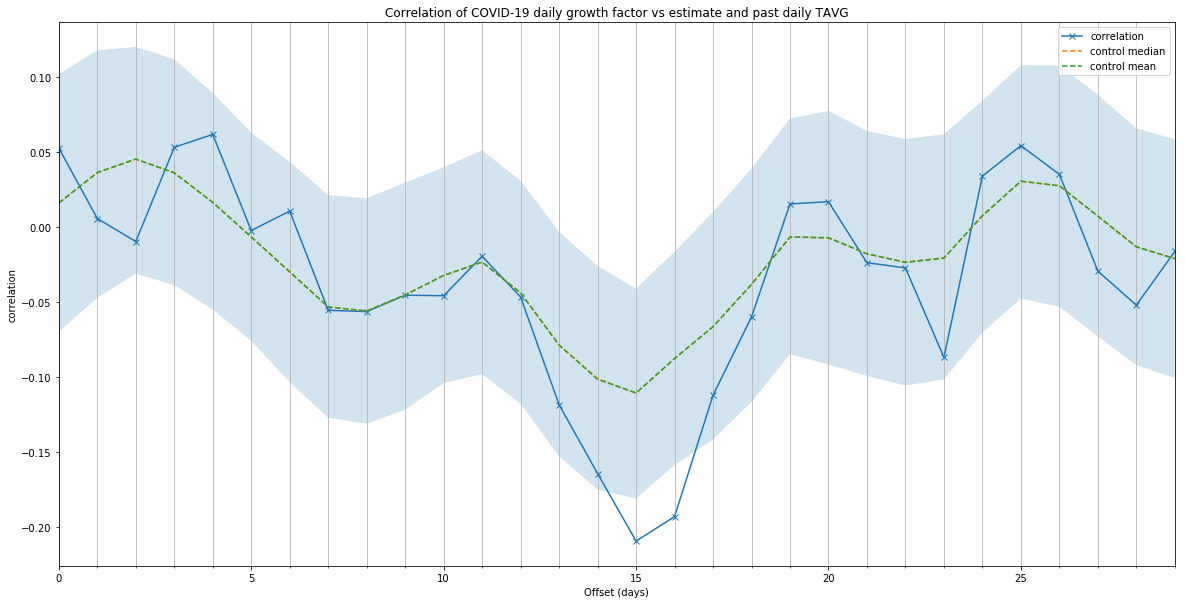

In [49]:
plot_corr(quantiles=False)

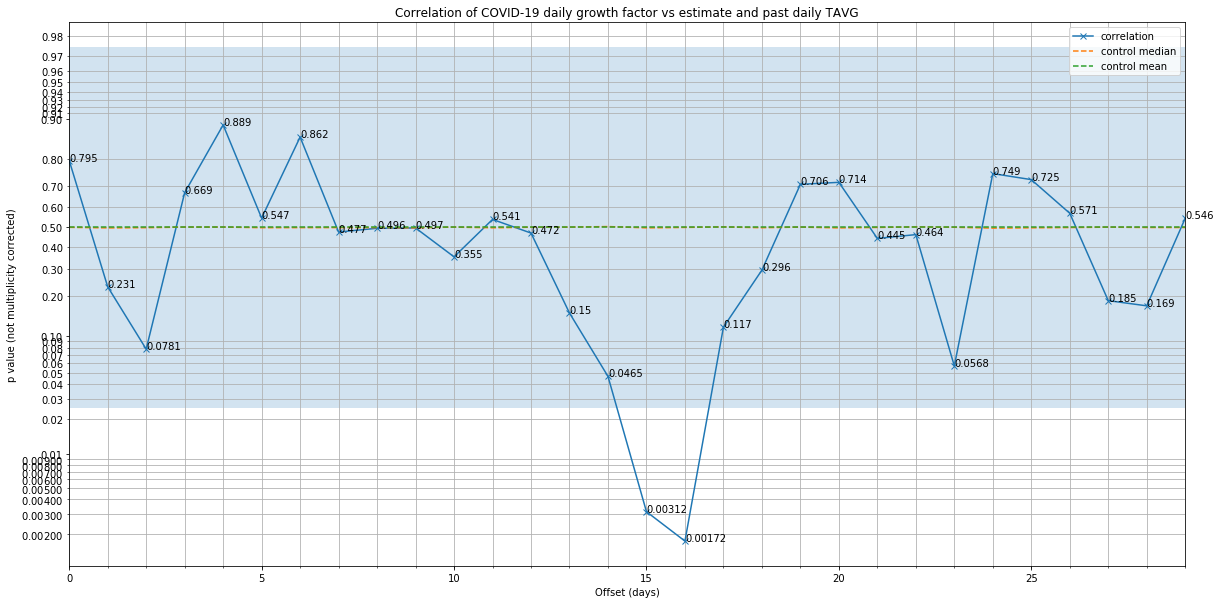

In [50]:
plot_corr(quantiles=True)